# ReactionToOffensiveMotion

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

games = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/games.csv")
plays = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/plays.csv")
players = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/players.csv")
player_play = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/player_play.csv")
week1 = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/tracking_week_1.csv")

Finding big pass plays

In [12]:
import pandas as pd

def find_big_passing_plays_with_week(plays_df, games_df):
    big_plays = plays_df[(plays_df["yardsGained"] > 40) & (plays_df["isDropback"] == True)][["gameId", "playId"]]

    big_plays_with_week = big_plays.merge(games_df[["gameId", "week"]], on="gameId", how="left")

    return big_plays_with_week

In [13]:
big_passing_plays_with_week = find_big_passing_plays_with_week(plays, games)
week1_plays = big_passing_plays_with_week[big_passing_plays_with_week["week"] == 1]

## SQL Queries to Find Offensive Motion

In [14]:
import pandas as pd
import sqlite3
conn = sqlite3.connect(":memory:")

games.to_sql("games", conn, index=False, if_exists="replace")
plays.to_sql("plays", conn, index=False, if_exists="replace")
player_play.to_sql("player_play", conn, index=False, if_exists="replace")
players.to_sql("players", conn, index=False, if_exists="replace")
week1.to_sql("week1", conn, index=False, if_exists="replace")

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1533d6bd6bc0>>
Traceback (most recent call last):
  File "/home/tun70127/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


7104700

In [16]:
motion_query = """
    SELECT p.gameId, p.playId, p.nflId
    FROM player_play p
    JOIN plays pp on (p.gameId = pp.gameId AND p.playId = pp.playId)
    JOIN games g ON p.gameId = g.gameId
    WHERE g.week = 1 AND p.motionSinceLineset = 1 AND pff_manZone = "Zone"
"""
motion_results = pd.read_sql(motion_query, conn)
print(motion_results.shape)

shift_query = """
    SELECT p.gameId, p.playId, p.nflId
    FROM player_play p
    JOIN games g ON p.gameId = g.gameId
    WHERE g.week = 1 AND p.shiftSinceLineset = 1
"""
shift_results = pd.read_sql(shift_query, conn)

both_query = """
    SELECT p.gameId, p.playId, p.nflId
    FROM player_play p
    JOIN games g ON p.gameId = g.gameId
    WHERE g.week = 1 AND p.shiftSinceLineset = 1 AND p.motionSinceLineset = 1
"""
both_results = pd.read_sql(both_query, conn)
print(motion_results.shape)

(1045, 3)
(1045, 3)


##### Plays Where Multiple Players Go Into Motion

In [ ]:
motion_play_counts = motion_results.groupby(['gameId', 'playId']).size().reset_index(name='player_count')

multiple_motion_plays = motion_play_counts[motion_play_counts['player_count'] > 1]

print(f"Number of plays where multiple players were in motion: {len(multiple_motion_plays)}")

print(multiple_motion_plays.head())

Number of plays where multiple players were in motion: 162
        gameId  playId  player_count
5   2022090800     299             3
8   2022090800     393             2
14  2022090800     721             3
17  2022090800     933             2
19  2022090800    1102             5


##### Query to Check Individual Players Velocity Trends

In [ ]:
acceleration_query = """
    SELECT w1.s, w1.frameId
    FROM week1 w1
    WHERE gameId = 2022091102 AND playId = 2415 AND nflId = 52433
"""
acceleration_results = pd.read_sql(acceleration_query, conn)


print(acceleration_results[0:60])
print(acceleration_results[60:101])
print(acceleration_results[101:165])
#print(acceleration_results[151:201])

       s  frameId
0   0.19        1
1   0.43        2
2   0.89        3
3   1.45        4
4   1.89        5
5   2.28        6
6   2.49        7
7   2.74        8
8   2.88        9
9   2.93       10
10  2.93       11
11  2.95       12
12  2.98       13
13  3.05       14
14  3.01       15
15  2.99       16
16  2.98       17
17  2.97       18
18  2.97       19
19  2.91       20
20  2.87       21
21  2.82       22
22  2.75       23
23  2.72       24
24  2.65       25
25  2.56       26
26  2.47       27
27  2.35       28
28  2.27       29
29  2.20       30
30  2.15       31
31  2.02       32
32  1.97       33
33  1.88       34
34  1.77       35
35  1.64       36
36  1.54       37
37  1.37       38
38  1.24       39
39  0.93       40
40  0.75       41
41  0.66       42
42  0.58       43
43  0.51       44
44  0.47       45
45  0.45       46
46  0.39       47
47  0.34       48
48  0.29       49
49  0.13       50
50  0.17       51
51  0.13       52
52  0.23       53
53  0.26       54
54  0.23  

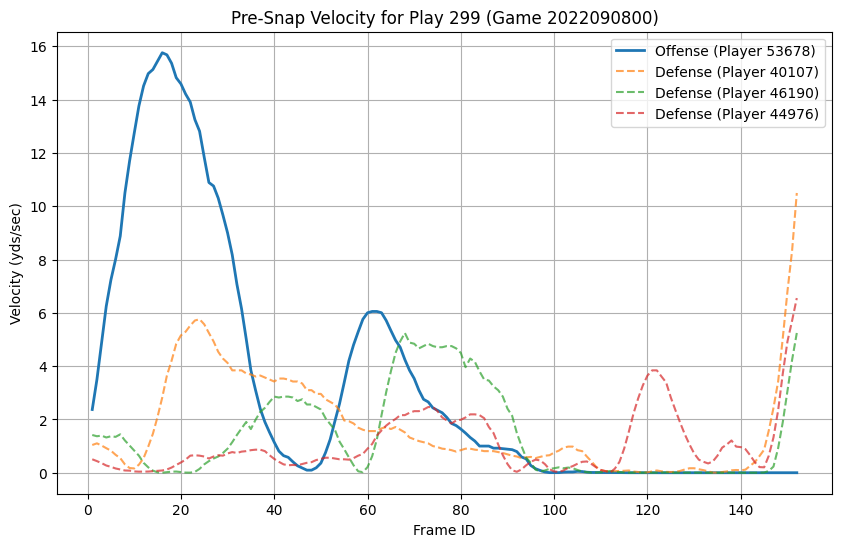

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_pre_snap_velocities(conn, game_id, play_id, offense_player_id, defensive_player_ids):
    """
    Plots velocity over time for a motioning offensive player and defensive players before the snap.
    
    Args:
    - conn: SQLite database connection.
    - game_id: Game identifier.
    - play_id: Play identifier.
    - offense_player_id: Player ID of the motioning offensive player.
    - defensive_player_ids: List of defensive player IDs to compare reactions.

    Returns:
    - A visualization of velocity vs. frameId for the selected players.
    """
    query = f"""
        SELECT s, frameId, nflId, frameType
        FROM week1
        WHERE gameId = {game_id} AND playId = {play_id}
        AND frameType = 'BEFORE_SNAP'
        ORDER BY frameId
    """
    tracking_data = pd.read_sql(query, conn)

    if tracking_data.empty:
        print("No data found for this play! Check gameId and playId.")
        return

    # Plot offensive motioning player's velocity
    plt.figure(figsize=(10, 6))
    
    offense_data = tracking_data[tracking_data["nflId"] == offense_player_id]
    plt.plot(offense_data["frameId"],  offense_data["s"]**2, label=f"Offense (Player {offense_player_id})", linewidth=2)

    
    # Plot defensive players' velocities
    for def_id in defensive_player_ids:
        defense_data = tracking_data[tracking_data["nflId"] == def_id]
        plt.plot(defense_data["frameId"], defense_data["s"]**2, linestyle='dashed', alpha=0.7, label=f"Defense (Player {def_id})")
    
    
    # Graph settings
    plt.xlabel("Frame ID")
    plt.ylabel("Velocity (yds/sec)")
    plt.title(f"Pre-Snap Velocity for Play {play_id} (Game {game_id})")
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

'''
# Example usage
game_id_to_test = 2022090800
play_id_to_test = 299
offense_player_id_to_test = 53678  # Replace with the motioning offensive player's ID
defensive_players_to_test = [44976, 54650, 46190]
#defensive_players_to_test = [46190]  # Replace with defensive players reacting

plot_pre_snap_velocities(conn, game_id_to_test, play_id_to_test, offense_player_id_to_test, defensive_players_to_test)
'''
game_id_to_test = 2022090800
play_id_to_test =  299
offense_player_id_to_test =  53678  # Replace with the motioning offensive player's ID
defensive_players_to_test = [40107, 46190, 44976]


plot_pre_snap_velocities(conn, game_id_to_test, play_id_to_test, offense_player_id_to_test, defensive_players_to_test)

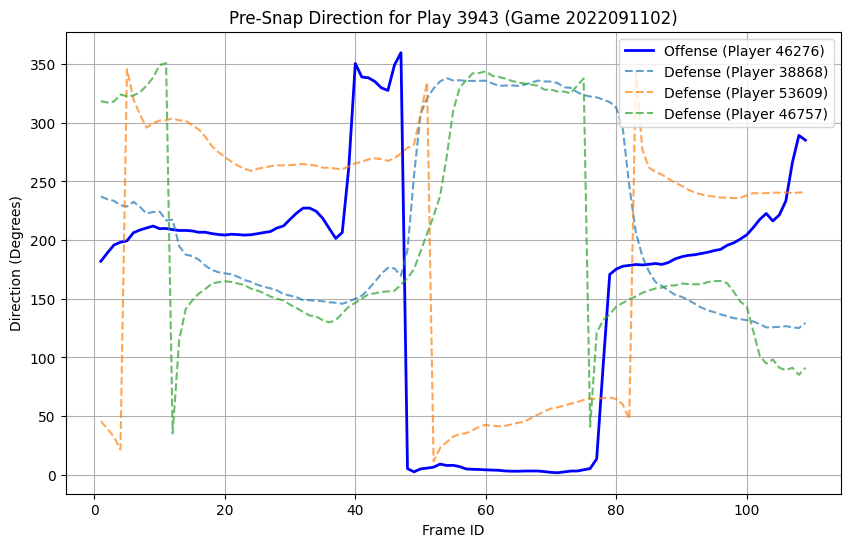

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_direction_change(conn, game_id, play_id, offense_player_id, defensive_player_ids):
    """
    Plots direction (dir) over time for the motioning offensive player and defensive players before the snap.
    
    Args:
    - conn: SQLite database connection.
    - game_id: Game identifier.
    - play_id: Play identifier.
    - offense_player_id: Player ID of the motioning offensive player.
    - defensive_player_ids: List of defensive player IDs to compare reactions.

    Returns:
    - A visualization of direction (degrees) vs. frameId for the selected players.
    """
    query = f"""
        SELECT dir, frameId, nflId, frameType
        FROM week1
        WHERE gameId = {game_id} AND playId = {play_id}
        AND frameType = 'BEFORE_SNAP'  -- Pre-snap frames only
        ORDER BY frameId
    """
    tracking_data = pd.read_sql(query, conn)

    if tracking_data.empty:
        print("⚠️ No data found for this play! Check gameId and playId.")
        return

    # Plot offensive player's direction
    plt.figure(figsize=(10, 6))
    
    offense_data = tracking_data[tracking_data["nflId"] == offense_player_id]
    plt.plot(offense_data["frameId"], offense_data["dir"], label=f"Offense (Player {offense_player_id})", linewidth=2, color='blue')

    # Plot defensive players' directions
    for def_id in defensive_player_ids:
        defense_data = tracking_data[tracking_data["nflId"] == def_id]
        plt.plot(defense_data["frameId"], defense_data["dir"], linestyle='dashed', alpha=0.7, label=f"Defense (Player {def_id})")

    # Graph settings
    plt.xlabel("Frame ID")
    plt.ylabel("Direction (Degrees)")
    plt.title(f"Pre-Snap Direction for Play {play_id} (Game {game_id})")
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

    '''
# Example usage
game_id_to_test = 2022090800
play_id_to_test = 299
offense_player_id_to_test = 53678  # Replace with the motioning offensive player's ID
defensive_players_to_test = [44976, 54650, 46190]
#defensive_players_to_test = [46190]  # Replace with defensive players reacting
'''
game_id_to_test = 2022091102   
play_id_to_test =  3943 
offense_player_id_to_test =  46276  # Replace with the motioning offensive player's ID
defensive_players_to_test = [38868, 53609, 46757]

plot_direction_change(conn, game_id_to_test, play_id_to_test, offense_player_id_to_test, defensive_players_to_test)


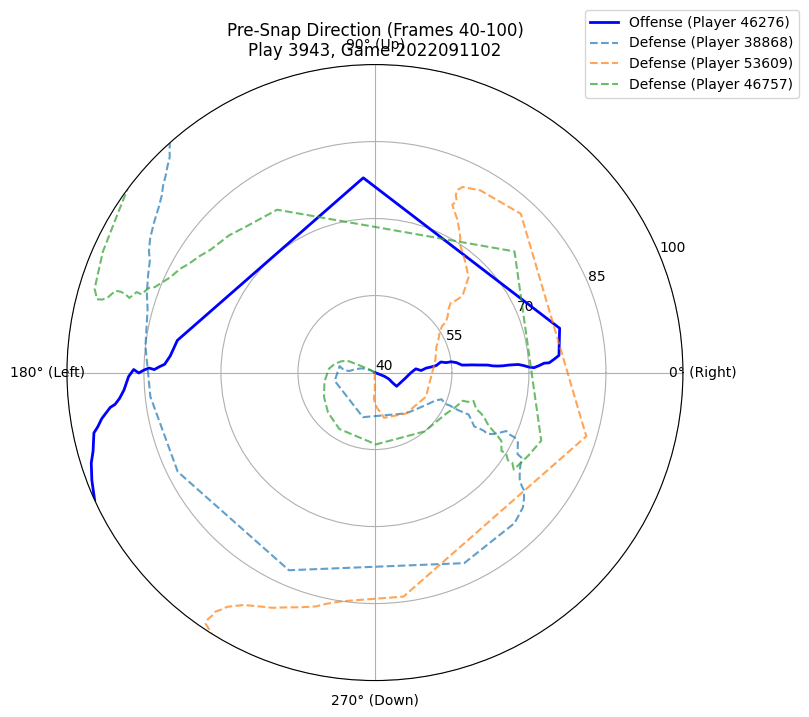

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_direction_polar(conn, game_id, play_id, offense_player_id, defensive_player_ids, start_frame, end_frame):
    """
    Plots a polar (circular) graph of player direction over time, within a specified frame range.
    
    Args:
    - conn: SQLite database connection.
    - game_id: Game identifier.
    - play_id: Play identifier.
    - offense_player_id: Player ID of the motioning offensive player.
    - defensive_player_ids: List of defensive player IDs to compare reactions.
    - start_frame: The first frame to include in the plot.
    - end_frame: The last frame to include in the plot.

    Returns:
    - A circular plot (polar graph) showing direction trends among players.
    """
    query = f"""
        SELECT dir, frameId, nflId, frameType
        FROM week1
        WHERE gameId = {game_id} AND playId = {play_id}
        AND frameType = 'BEFORE_SNAP'
        AND frameId BETWEEN {start_frame} AND {end_frame}
        ORDER BY frameId
    """
    tracking_data = pd.read_sql(query, conn)

    if tracking_data.empty:
        print("⚠️ No data found for this play in the specified frame range! Check gameId, playId, and frame range.")
        return

    tracking_data["dir_rad"] = np.radians(tracking_data["dir"])  # Convert direction to radians

    # Create a polar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

    # Adjust radial (y-axis) limits to remove empty space
    ax.set_ylim(start_frame, end_frame)

    # Plot offensive player's direction
    offense_data = tracking_data[tracking_data["nflId"] == offense_player_id]
    ax.plot(offense_data["dir_rad"], offense_data["frameId"], label=f"Offense (Player {offense_player_id})", linewidth=2, color='blue')

    # Plot defensive players' directions
    for def_id in defensive_player_ids:
        defense_data = tracking_data[tracking_data["nflId"] == def_id]
        ax.plot(defense_data["dir_rad"], defense_data["frameId"], linestyle='dashed', alpha=0.7, label=f"Defense (Player {def_id})")

    # Set up circular axis labels
    ax.set_xticks(np.radians([0, 90, 180, 270]))
    ax.set_xticklabels(["0° (Right)", "90° (Up)", "180° (Left)", "270° (Down)"])

    # Set radial axis (frames) ticks to be more readable
    ax.set_yticks(np.linspace(start_frame, end_frame, 5))  
    ax.set_yticklabels(np.linspace(start_frame, end_frame, 5, dtype=int))  

    # Set title and legend
    ax.set_title(f"Pre-Snap Direction (Frames {start_frame}-{end_frame})\nPlay {play_id}, Game {game_id}")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

    plt.show()

# Example usage
game_id_to_test = 2022091102   
play_id_to_test =  3943 
offense_player_id_to_test =  46276  # Replace with the motioning offensive player's ID
defensive_players_to_test = [38868, 53609, 46757]
start_frame_to_test = 40
end_frame_to_test = 100

plot_direction_polar(conn, game_id_to_test, play_id_to_test, offense_player_id_to_test, defensive_players_to_test, start_frame_to_test, end_frame_to_test)


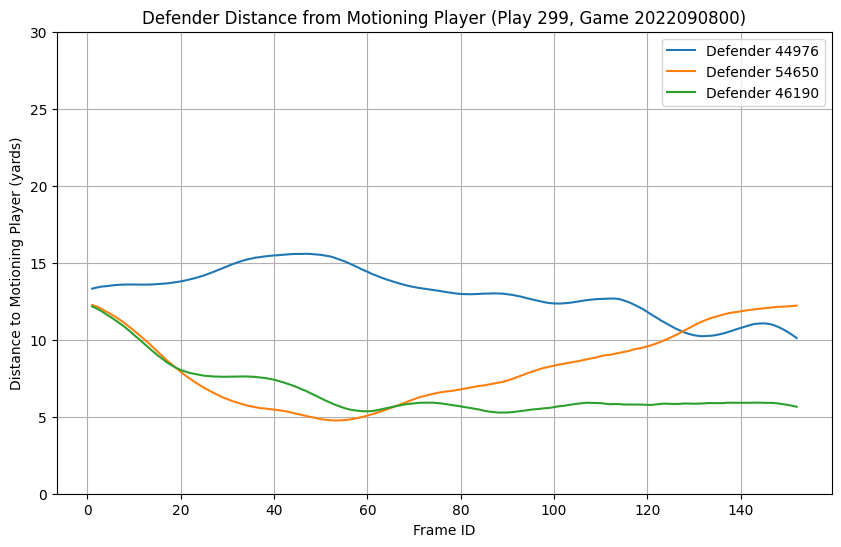

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_defender_distance(conn, game_id, play_id, offense_player_id, defensive_player_ids):
    """
    Plots the distance between the motioning offensive player and defensive players over time.
    
    Args:
    - conn: SQLite database connection.
    - game_id: Game identifier.
    - play_id: Play identifier.
    - offense_player_id: Player ID of the motioning offensive player.
    - defensive_player_ids: List of defensive player IDs to compare.

    Returns:
    - A visualization of how defender distance changes over time.
    """
    query = f"""
        SELECT x, y, frameId, nflId, frameType
        FROM week1
        WHERE gameId = {game_id} AND playId = {play_id}
        AND frameType = 'BEFORE_SNAP'  -- Pre-snap frames only
        ORDER BY frameId
    """
    tracking_data = pd.read_sql(query, conn)

    if tracking_data.empty:
        print("⚠️ No data found for this play! Check gameId and playId.")
        return

    # Get offensive player movement
    offense_data = tracking_data[tracking_data["nflId"] == offense_player_id]

    plt.figure(figsize=(10, 6))

    for def_id in defensive_player_ids:
        defense_data = tracking_data[tracking_data["nflId"] == def_id]

        # Compute Euclidean distance at each frame
        merged = pd.merge(offense_data, defense_data, on="frameId", suffixes=("_off", "_def"))
        merged["distance"] = np.sqrt((merged["x_off"] - merged["x_def"])**2 + (merged["y_off"] - merged["y_def"])**2)

        plt.plot(merged["frameId"], merged["distance"], label=f"Defender {def_id}")

    # Graph settings
    plt.xlabel("Frame ID")
    plt.ylabel("Distance to Motioning Player (yards)")
    plt.title(f"Defender Distance from Motioning Player (Play {play_id}, Game {game_id})")
    plt.legend()
    plt.grid(True)
    plt.ylim([0,30])

    # Show plot
    plt.show()

# Example usage
game_id_to_test = 2022090800
play_id_to_test = 299
offense_player_id_to_test = 53678  # Motioning offensive player
defensive_players_to_test = [44976, 54650, 46190]  # Defensive players to compare

plot_defender_distance(conn, game_id_to_test, play_id_to_test, offense_player_id_to_test, defensive_players_to_test)


## Getting Offensive Motion Frames

In [3]:
import numpy as np
import pandas as pd

def get_motion_segments_refined(tracking_df, game_id, play_id, player_id, velocity_threshold=2, peak_difference_threshold=0.5):
    """
    Identifies motion start and end frames using peak velocity detection, ignoring small movements.

    Args:
    - tracking_df (DataFrame): Tracking data containing velocity (s) and frameId.
    - game_id (int): Game ID.
    - play_id (int): Play ID.
    - player_id (int): Player ID (offensive motion player).
    - velocity_threshold (float): Squared velocity threshold to detect motion.
    - peak_difference_threshold (float): Ratio to determine if a second peak is significant.

    Returns:
    - List of (motion_start, motion_end) tuples.
    """

    player_tracking = tracking_df[
        (tracking_df['gameId'] == game_id) & 
        (tracking_df['playId'] == play_id) & 
        (tracking_df['nflId'] == player_id) &
        (tracking_df['frameType'] == 'BEFORE_SNAP')
    ].sort_values(by="frameId").reset_index(drop=True)

    if player_tracking.empty:
        print("⚠️ No data found for this player in the given play!")
        return []

    player_tracking['velocity_squared'] = player_tracking['s'] ** 2
    
    total_frames = player_tracking['frameId'].max()

    start_frame = int(total_frames * .33) - 1

    valid_tracking = player_tracking[player_tracking['frameId'] >= start_frame]

    primary_peak_idx = valid_tracking['velocity_squared'].idxmax()
    
    primary_peak_val = valid_tracking.loc[primary_peak_idx, 'velocity_squared']
    
    peak_frame = valid_tracking.loc[primary_peak_idx, 'frameId']

    player_tracking.set_index("frameId", inplace=True)

    motion_start = valid_tracking['frameId'].min()

    motion_end = valid_tracking['frameId'].max()

    for i in range(primary_peak_idx, -1, -1):
        if(i == start_frame - 1):
            break
        if valid_tracking.loc[i, 'velocity_squared'] < velocity_threshold:
            motion_start = valid_tracking.loc[i, 'frameId']
            break
    
    for i in range(primary_peak_idx, motion_end):
        if valid_tracking.loc[i, 'velocity_squared'] < velocity_threshold:
            motion_end = valid_tracking.loc[i, 'frameId']
            break    

    motion_segments = [(int(motion_start), int(motion_end))]

    remaining_tracking = valid_tracking[
        (valid_tracking['frameId'] < motion_start) | (valid_tracking['frameId'] > motion_end)
    ]

    if not remaining_tracking.empty:
        secondary_peak_idx = remaining_tracking['velocity_squared'].idxmax()
        secondary_peak_val = remaining_tracking.loc[secondary_peak_idx, 'velocity_squared']

        if secondary_peak_val >= primary_peak_val * peak_difference_threshold:
            peak_frame_2 = remaining_tracking.loc[secondary_peak_idx, 'frameId']

            motion_start_2, motion_end_2 = valid_tracking['frameId'].min(), valid_tracking['frameId'].max()

            for i in range(secondary_peak_idx, -1, -1):
                 if(i == start_frame - 1):
                    break
                 if valid_tracking.loc[i, 'velocity_squared'] < velocity_threshold:
                    motion_start_2 = valid_tracking.loc[i, 'frameId']
                    break

            for i in range(secondary_peak_idx, motion_end_2):
                if valid_tracking.loc[i, 'velocity_squared'] < velocity_threshold:
                    motion_end_2 = valid_tracking.loc[i, 'frameId']
                    break

            motion_segments.append((int(motion_start_2), int(motion_end_2)))

    return motion_segments


'''game_id_to_test = 2022090800
play_id_to_test = 299
offense_player_id_to_test = 53678
defensive_players_to_test = []

motion_segments = get_motion_segments_refined(week1, game_id_to_test, play_id_to_test, offense_player_id_to_test)

print(f"Motion segments detected: {motion_segments}")

game_id_to_test = 2022091102 
play_id_to_test = 3943
offense_player_id_to_test = 46276
defensive_players_to_test = []

motion_segments = get_motion_segments_refined(week1, game_id_to_test, play_id_to_test, offense_player_id_to_test)
print(f"Motion segments detected: {motion_segments}")'''

sample_plays = [
    (2022091103, 3011,44860)
]

for game_id_to_test, play_id_to_test, offense_player_id_to_test in sample_plays:
    motion_segments = get_motion_segments_refined(week1, game_id_to_test, play_id_to_test, offense_player_id_to_test)
    print(f"Motion segments detected: {motion_segments}")


Motion segments detected: [(95, 115)]


### Zone Plays: Calculating Similarity Between Offensive Players Motion and Defenders

In [ ]:
import numpy as np

def calculate_defensive_similarity(df, game_id, play_id, offense_player_id, defense_player_ids, start_frame, end_frame, lambda_penalty=0):
    """
    Computes the average cosine similarity between the offensive player's movement and each defensive player's movement.

    Args:
    - df (DataFrame): Tracking data containing velocity (s) and direction (dir).
    - game_id (int): Game identifier.
    - play_id (int): Play identifier.
    - offense_player_id (int): The motioning offensive player's ID.
    - defense_player_ids (list): List of defensive player IDs.
    - start_frame (int): Frame to start extracting data.
    - end_frame (int): Frame to stop extracting data.

    Returns:
    - best_defender_id (int): The defensive player ID with the highest similarity.
    - defender_scores (dict): Dictionary mapping each defender ID to their average similarity score.
    """

    # Filter data for the given play and frame range
    play_data = df[
        (df["gameId"] == game_id) & 
        (df["playId"] == play_id) & 
        (df["frameId"] >= start_frame) & 
        (df["frameId"] <= end_frame)
    ]

    # Extract offensive player's motion data
    offense_data = play_data[play_data["nflId"] == offense_player_id]
    
    if offense_data.empty:
        print("⚠️ No offensive player data found in this range!")
        return None, {}

    # Convert offense player movement to vectors (frame-wise)
    offense_vectors = {
        frame: (
            row["s"] * np.cos(np.radians(row["dir"])),  # V_x
            row["s"] * np.sin(np.radians(row["dir"])),   # V_y
            row["s"]
        ) 
        for frame, row in offense_data.set_index("frameId").iterrows()
    }

    defender_scores = {def_id: [] for def_id in defense_player_ids}  # Store per-frame similarity

    # Iterate through each defensive player
    for def_id in defense_player_ids:
        defense_data = play_data[play_data["nflId"] == def_id]

        if defense_data.empty:
            print(f"⚠️ No data found for defender {def_id}, skipping.")
            continue

        # Convert defender movement to vectors (frame-wise)
        defense_vectors = {
            frame: (
                row["s"] * np.cos(np.radians(row["dir"])),  # V_x
                row["s"] * np.sin(np.radians(row["dir"])),  # V_y
                row["s"]
            ) 
            for frame, row in defense_data.set_index("frameId").iterrows()
        }

        # Loop through each frame to calculate cosine similarity
        for frame in offense_vectors.keys():
            if frame in defense_vectors:
                V_x1, V_y1, s1 = offense_vectors[frame]
                V_x2, V_y2, s2 = defense_vectors[frame]

                # Compute dot product
                dot_product = (V_x1 * V_x2) + (V_y1 * V_y2)

                # Compute magnitudes
                mag1 = np.sqrt(V_x1**2 + V_y1**2)
                mag2 = np.sqrt(V_x2**2 + V_y2**2)

                # Avoid division by zero
                if mag1 > 0 and mag2 > 0:
                    cosine_sim = dot_product / (mag1 * mag2)
                else:
                    cosine_sim = 0  # If either magnitude is zero, similarity is 0

                speed_penalty = lambda_penalty * abs(s1 - s2)

                # Final reaction score
                reaction_score = cosine_sim - speed_penalty

                # Store reaction score
                defender_scores[def_id].append(reaction_score)

    # Compute average similarity for each defender
    avg_defender_scores = {
        def_id: np.mean(scores) if scores else -1  # Use -1 if no valid scores
        for def_id, scores in defender_scores.items()
    }

    # Identify the best defender based on highest average similarity
    best_defender_id = max(avg_defender_scores, key=avg_defender_scores.get) if avg_defender_scores else None

    print(f"🛡️ Best defender: {best_defender_id} (Highest similarity)")
    return best_defender_id, avg_defender_scores

game_id_to_test = 2022090800
play_id_to_test = 299
offense_player_id_to_test = 53678 
defense_players_to_test = [46190, 44976, 40107, 46085]  # Example defensive players
start_frame = 40
end_frame = 80

'''game_id_to_test = 2022091102 
play_id_to_test = 3943
offense_player_id_to_test = 46276
defense_players_to_test = [38868, 53609, 46757]  # Example defensive players
start_frame = 48
end_frame = 103'''

best_defender, defender_scores = calculate_defensive_similarity(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)

print("Defender Scores:", defender_scores)


🛡️ Best defender: 44976 (Highest similarity)
Defender Scores: {46190: np.float64(0.34243049303667084), 44976: np.float64(0.6841733554674045), 40107: np.float64(0.5765996684887357), 46085: np.float64(0.19556057587341488)}


In [ ]:
import numpy as np

def calculate_defensive_similarity_with_distance(df, game_id, play_id, offense_player_id, defense_player_ids, start_frame, end_frame, alpha_distance=0.1):
    """
    Computes the average reaction score based on cosine similarity and distance change.

    Args:
    - df (DataFrame): Tracking data containing velocity (s), direction (dir), and position (x, y).
    - game_id (int): Game identifier.
    - play_id (int): Play identifier.
    - offense_player_id (int): The motioning offensive player's ID.
    - defense_player_ids (list): List of defensive player IDs.
    - start_frame (int): Frame to start extracting data.
    - end_frame (int): Frame to stop extracting data.
    - alpha_distance (float): Weight for distance factor.

    Returns:
    - best_defender_id (int): The defensive player ID with the highest reaction score.
    - defender_scores (dict): Dictionary mapping each defender ID to their final score.
    """

    # Filter data for the given play and frame range
    play_data = df[
        (df["gameId"] == game_id) & 
        (df["playId"] == play_id) & 
        (df["frameId"] >= start_frame) & 
        (df["frameId"] <= end_frame)
    ]

    # Extract offensive player's motion data
    offense_data = play_data[play_data["nflId"] == offense_player_id]

    if offense_data.empty:
        print("⚠️ No offensive player data found in this range!")
        return None, {}

    # Convert offensive player movement to vectors (frame-wise)
    offense_vectors = {}
    offense_positions = {}

    for frame, row in offense_data.set_index("frameId").iterrows():
        V_x = row["s"] * np.cos(np.radians(row["dir"]))  # Velocity X
        V_y = row["s"] * np.sin(np.radians(row["dir"]))  # Velocity Y
        offense_vectors[frame] = (V_x, V_y)  # (V_x, V_y)
        offense_positions[frame] = (row["x"], row["y"])  # Position (x, y)

    defender_scores = {def_id: [] for def_id in defense_player_ids}  # Store per-frame similarity
    defender_distance_changes = {}

    # Iterate through each defensive player
    for def_id in defense_player_ids:
        defense_data = play_data[play_data["nflId"] == def_id]

        if defense_data.empty:
            print(f"⚠️ No data found for defender {def_id}, skipping.")
            continue

        # Convert defender movement to vectors (frame-wise)
        defense_vectors = {}
        defense_positions = {}

        for frame, row in defense_data.set_index("frameId").iterrows():
            V_x = row["s"] * np.cos(np.radians(row["dir"]))  # Velocity X
            V_y = row["s"] * np.sin(np.radians(row["dir"]))  # Velocity Y
            defense_vectors[frame] = (V_x, V_y)  # (V_x, V_y)
            defense_positions[frame] = (row["x"], row["y"])  # Position (x, y)

        # Compute initial & final distance between offense & defense
        if start_frame in offense_positions and end_frame in offense_positions and start_frame in defense_positions and end_frame in defense_positions:
            start_off_x, start_off_y = offense_positions[start_frame]
            end_off_x, end_off_y = offense_positions[end_frame]

            start_def_x, start_def_y = defense_positions[start_frame]
            end_def_x, end_def_y = defense_positions[end_frame]

            dist_start = np.sqrt((start_off_x - start_def_x) ** 2 + (start_off_y - start_def_y) ** 2)
            dist_end = np.sqrt((end_off_x - end_def_x) ** 2 + (end_off_y - end_def_y) ** 2)

            defender_distance_changes[def_id] = abs(dist_start - dist_end)

        # Loop through each frame to calculate reaction score
        for frame in offense_vectors.keys():
            if frame in defense_vectors:
                V_x1, V_y1 = offense_vectors[frame]  # Offense
                V_x2, V_y2 = defense_vectors[frame]  # Defense

                # Compute dot product
                dot_product = (V_x1 * V_x2) + (V_y1 * V_y2)

                # Compute magnitudes
                mag1 = np.sqrt(V_x1**2 + V_y1**2)
                mag2 = np.sqrt(V_x2**2 + V_y2**2)

                # Avoid division by zero
                cosine_sim = dot_product / (mag1 * mag2) if mag1 > 0 and mag2 > 0 else 0

                # Store reaction score
                defender_scores[def_id].append(cosine_sim)

    # Normalize distance changes
    max_distance_change = max(defender_distance_changes.values(), default=1)
    for def_id in defender_distance_changes:
        defender_distance_changes[def_id] = 1 - (defender_distance_changes[def_id] / max_distance_change)

    # Compute final scores
    final_scores = {def_id: np.mean(scores) + alpha_distance * defender_distance_changes.get(def_id, 0) for def_id, scores in defender_scores.items()}

    # Identify best defender
    best_defender_id = max(final_scores, key=final_scores.get) if final_scores else None

    print(f"🛡️ Best defender: {best_defender_id} (Final score)")
    return best_defender_id, final_scores

game_id_to_test = 2022090800
play_id_to_test = 299
offense_player_id_to_test = 53678 #43399 
defense_players_to_test = [46190, 44976, 40107, 46085]  # Example defensive players
start_frame = 53
end_frame = 78

best_defender, defender_scores = calculate_defensive_similarity_with_distance(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)

print("Defender Scores:", defender_scores)

🛡️ Best defender: 44976 (Final score)
Defender Scores: {46190: np.float64(0.9699989523237872), 44976: np.float64(0.9951881283273265), 40107: np.float64(0.7378292341586764), 46085: np.float64(0.16441299940362245)}


### REFINED

In [17]:
import numpy as np

def calculate_defensive_similarity_with_movement_penalty(df, game_id, play_id, offense_player_id, defense_player_ids, start_frame, end_frame, alpha_distance=0.05, beta_movement=0.05):
    """
    Computes the average reaction score based on cosine similarity, distance change, and movement penalty.

    Args:
    - df (DataFrame): Tracking data containing velocity (s), direction (dir), and position (x, y).
    - game_id (int): Game identifier.
    - play_id (int): Play identifier.
    - offense_player_id (int): The motioning offensive player's ID.
    - defense_player_ids (list): List of defensive player IDs.
    - start_frame (int): Frame to start extracting data.
    - end_frame (int): Frame to stop extracting data.
    - alpha_distance (float): Weight for distance factor.
    - beta_movement (float): Weight for movement penalty.

    Returns:
    - best_defender_id (int): The defensive player ID with the highest reaction score.
    - defender_scores (dict): Dictionary mapping each defender ID to their final score.
    """

    # Filter data for the given play and frame range
    play_data = df[
        (df["gameId"] == game_id) & 
        (df["playId"] == play_id) & 
        (df["frameId"] >= start_frame) & 
        (df["frameId"] <= end_frame)
    ]

    # Extract offensive player's motion data
    offense_data = play_data[play_data["nflId"] == offense_player_id]
    if offense_data.empty:
        print("⚠️ No offensive player data found in this range!")
        return None, {}

    # Store offensive player (x, y) positions
    offense_positions = {frame: (row["x"], row["y"]) for frame, row in offense_data.set_index("frameId").iterrows()}

    defender_scores = {def_id: [] for def_id in defense_player_ids}
    defender_distance_changes = {}
    defender_movements = {}

    # Iterate through each defensive player
    for def_id in defense_player_ids:
        defense_data = play_data[play_data["nflId"] == def_id]

        if defense_data.empty:
            print(f"⚠️ No data found for defender {def_id}, skipping.")
            continue

        # Store defender (x, y) positions
        defense_positions = {frame: (row["x"], row["y"]) for frame, row in defense_data.set_index("frameId").iterrows()}

        # Compute distance change
        if start_frame in offense_positions and end_frame in offense_positions and start_frame in defense_positions and end_frame in defense_positions:
            start_off_x, start_off_y = offense_positions[start_frame]
            end_off_x, end_off_y = offense_positions[end_frame]

            start_def_x, start_def_y = defense_positions[start_frame]
            end_def_x, end_def_y = defense_positions[end_frame]

            dist_start = np.sqrt((start_off_x - start_def_x) ** 2 + (start_off_y - start_def_y) ** 2)
            dist_end = np.sqrt((end_off_x - end_def_x) ** 2 + (end_off_y - end_def_y) ** 2)

            defender_distance_changes[def_id] = abs(dist_start - dist_end)

            # Compute total movement of the defender
            defender_movements[def_id] = np.sqrt((end_def_x - start_def_x) ** 2 + (end_def_y - start_def_y) ** 2)

        # Loop through each frame to calculate cosine similarity
        for frame in offense_positions.keys():
            if frame in defense_positions:
                V_x1 = offense_data.loc[offense_data["frameId"] == frame, "s"].values[0] * np.cos(np.radians(offense_data.loc[offense_data["frameId"] == frame, "dir"].values[0]))
                V_y1 = offense_data.loc[offense_data["frameId"] == frame, "s"].values[0] * np.sin(np.radians(offense_data.loc[offense_data["frameId"] == frame, "dir"].values[0]))

                V_x2 = defense_data.loc[defense_data["frameId"] == frame, "s"].values[0] * np.cos(np.radians(defense_data.loc[defense_data["frameId"] == frame, "dir"].values[0]))
                V_y2 = defense_data.loc[defense_data["frameId"] == frame, "s"].values[0] * np.sin(np.radians(defense_data.loc[defense_data["frameId"] == frame, "dir"].values[0]))

                # Compute cosine similarity
                dot_product = (V_x1 * V_x2) + (V_y1 * V_y2)
                mag1 = np.sqrt(V_x1**2 + V_y1**2)
                mag2 = np.sqrt(V_x2**2 + V_y2**2)
                cosine_sim = dot_product / (mag1 * mag2) if mag1 > 0 and mag2 > 0 else 0

                # Store cosine similarity score
                defender_scores[def_id].append(cosine_sim)

    # Normalize distance changes
    max_distance_change = max(defender_distance_changes.values(), default=1)
    for def_id in defender_distance_changes:
        defender_distance_changes[def_id] = 1 - (defender_distance_changes[def_id] / max_distance_change)

    # Normalize defender movement
    max_defender_movement = max(defender_movements.values(), default=1)
    for def_id in defender_movements:
        defender_movements[def_id] = defender_movements[def_id] / max_defender_movement  # Higher is better

    # Compute final scores
    final_scores = {
        def_id: np.mean(scores) + alpha_distance * defender_distance_changes.get(def_id, 0) - beta_movement * (1 - defender_movements.get(def_id, 0))
        for def_id, scores in defender_scores.items()
    }

    # Identify best defender
    best_defender_id = max(final_scores, key=final_scores.get) if final_scores else None

    print(f"🛡️ Best defender: {best_defender_id} (Final score)")
    return best_defender_id, final_scores

game_id_to_test = 2022090800
play_id_to_test = 299
offense_player_id_to_test = 53678 #43399
defense_players_to_test = [46190, 44976, 40107, 46085]  # Example defensive players
start_frame = 53
end_frame = 78

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame, end_frame
)

print("Defender Scores:", defender_scores)


🛡️ Best defender: 44976 (Final score)
Defender Scores: {46190: np.float64(0.5808938229093814), 44976: np.float64(0.9510642044802897), 40107: np.float64(0.7562837761351848), 46085: np.float64(0.2133401795468586)}


## Testing

In [ ]:
motion_query = """
    SELECT p.gameId, p.playId, p.nflId AS offense_nflId
    FROM player_play p
    JOIN plays pp ON p.gameId = pp.gameId AND p.playId = pp.playId
    JOIN games g ON p.gameId = g.gameId
    WHERE g.week = 1 AND p.motionSinceLineset = 1 AND pp.pff_manZone = "Man"
"""

motion_results = pd.read_sql(motion_query, conn)

random_motion_samples = motion_results.sample(n=10, random_state=42)

print(random_motion_samples)

sample_plays = [
    (2022091200, 2522, 40026),
    (2022091103, 3011, 44860),
    (2022091108, 2473, 39989),
    (2022091104, 2558, 45102),
    (2022091102, 2415, 52433),
    (2022091103, 3505, 43344),
    (2022091101,  686, 46104),
    (2022091110, 2720, 40011),
    (2022091113, 1587, 45052),
    (2022091104, 1528, 47834)
]

for game_id_to_test, play_id_to_test, offense_player_id_to_test in sample_plays:
    motion_segments = get_motion_segments_refined(week1, game_id_to_test, play_id_to_test, offense_player_id_to_test)
    print(f"Motion segments detected: {motion_segments}")

         gameId  playId  offense_nflId
183  2022091200    2522          40026
60   2022091103    3011          44860
124  2022091108    2473          39989
93   2022091104    2558          45102
63   2022091102    2415          52433
9    2022091103    3505          43344
147  2022091101     686          46104
158  2022091110    2720          40011
168  2022091113    1587          45052
33   2022091104    1528          47834
(138, 19)
total 138
start 47
Motion segments detected: [(48, 92)]
(131, 19)
total 131
start 44
Motion segments detected: [(95, 115)]
(85, 19)
total 85
start 28
Motion segments detected: [(28, 63)]
(177, 19)
total 177
start 60
Motion segments detected: [(132, 142), (102, 102)]
(122, 19)
total 122
start 41
Motion segments detected: [(68, 68), (66, 66)]
(96, 19)
total 96
start 32
Motion segments detected: [(32, 67)]
(138, 19)
total 138
start 47
Motion segments detected: [(93, 127)]
(113, 19)
total 113
start 38
Motion segments detected: [(97, 113)]
(109, 19)
total 109


In [ ]:
motion_query = """
    SELECT p.gameId, p.playId, p.nflId AS offense_nflId, p.teamAbbr AS team
    FROM player_play p
    JOIN plays pp ON p.gameId = pp.gameId AND p.playId = pp.playId
    JOIN games g ON p.gameId = g.gameId
    WHERE g.week = 1 AND p.motionSinceLineset = 1 AND pp.pff_manZone = "Zone"
"""

motion_results = pd.read_sql(motion_query, conn)

random_motion_samples = motion_results.sample(n=3, random_state=42)

print(random_motion_samples)


         gameId  playId  offense_nflId team
773  2022091103    1126          54517  PIT
280  2022091110     514          40011   KC
629  2022091102    3336          46331   SF


In [ ]:
que = """
    SELECT p.gameId, p.playId, p.nflId AS player_nflId, p.teamAbbr AS player_team
    FROM player_play p
    JOIN (
        SELECT 2022091200 AS gameId, 2522 AS playId, 'SEA' AS offense_team
        UNION ALL SELECT 2022091103, 1126, 'PIT'
        UNION ALL SELECT 2022091110, 514, 'KC'
        UNION ALL SELECT 2022091102, 3336, 'SF'
        UNION ALL SELECT 2022091102, 2415, 'SF'
        UNION ALL SELECT 2022091103, 3505, 'CIN'
        UNION ALL SELECT 2022091101,  686, 'CLE'
        UNION ALL SELECT 2022091110, 2720, 'KC'
        UNION ALL SELECT 2022091113, 1587, 'DAL'
        UNION ALL SELECT 2022091104, 1528, 'PHI'
    ) AS selected_plays
    ON p.gameId = selected_plays.gameId AND p.playId = selected_plays.playId
    WHERE p.teamAbbr <> selected_plays.offense_team
"""
results = pd.read_sql(que, conn)
print(results)

import pandas as pd

# Assuming 'results' contains the dataframe from the query execution
play_dict = {}

for _, row in results.iterrows():
    key = (row['gameId'], row['playId'])
    if key not in play_dict:
        play_dict[key] = []
    play_dict[key].append(row['player_nflId'])

# Print the dictionary
for play, players in play_dict.items():
    print(f"Game {play[0]}, Play {play[1]}: {players}")



         gameId  playId  player_nflId player_team
0    2022091200    2522         35459         DEN
1    2022091200    2522         42030         DEN
2    2022091200    2522         42393         DEN
3    2022091200    2522         42403         DEN
4    2022091200    2522         43387         DEN
..          ...     ...           ...         ...
105  2022091104    1528         47929         DET
106  2022091104    1528         47975         DET
107  2022091104    1528         52411         DET
108  2022091104    1528         53501         DET
109  2022091104    1528         54467         DET

[110 rows x 4 columns]
Game 2022091200, Play 2522: [35459, 42030, 42393, 42403, 43387, 45011, 46074, 47854, 53438, 53534, 53581]
Game 2022091103, Play 1126: [43299, 43350, 43455, 43641, 44872, 44915, 46123, 46138, 46146, 47855, 52473]
Game 2022091110, Play 514: [41403, 43376, 44848, 47816, 47848, 48032, 49410, 52416, 52522, 53445, 53565]
Game 2022091102, Play 3336: [37087, 42443, 44925, 45009, 45

In [20]:
game_id_to_test = 2022091200
play_id_to_test = 2522
offense_player_id_to_test = 40026
defense_players_to_test = [35459, 42030, 42393, 42403, 43387, 45011, 46074, 47854, 53438, 53534, 53581] # Example defensive players
start_frame = 48
end_frame = 92

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame+5, end_frame
)
print("Defender Scores:", defender_scores)

🛡️ Best defender: 42030 (Final score)
Defender Scores: {35459: np.float64(0.11711981973491442), 42030: np.float64(0.7556784514119762), 42393: np.float64(0.3718620321282176), 42403: np.float64(0.01985223182829355), 43387: np.float64(0.1583193825197763), 45011: np.float64(-0.2857861887691775), 46074: np.float64(0.13836080479780719), 47854: np.float64(-0.007309443884686649), 53438: np.float64(0.18725051810822135), 53534: np.float64(-0.5708282723930902), 53581: np.float64(0.6586398412213492)}


In [21]:
game_id_to_test = 2022091103
play_id_to_test = 3011
offense_player_id_to_test = 44860
defense_players_to_test = [37104, 43325, 44842, 44878, 44906, 45395, 46080, 46097, 46902, 52971, 54549] # Example defensive players
start_frame = 95
end_frame = 115

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame, end_frame
)
print("Defender Scores:", defender_scores)

🛡️ Best defender: 46902 (Final score)
Defender Scores: {37104: np.float64(-0.01383020994837228), 43325: np.float64(-0.01077949283894343), 44842: np.float64(-0.03065992549155465), 44878: np.float64(-0.29908314230662647), 44906: np.float64(-0.04077358013269146), 45395: np.float64(-0.4432409148190132), 46080: np.float64(-0.159872761856386), 46097: np.float64(0.5021973551219289), 46902: np.float64(0.9605596833714255), 52971: np.float64(-0.03024168618046275), 54549: np.float64(-0.010043522477634799)}


In [22]:
game_id_to_test = 2022091108
play_id_to_test = 2473
offense_player_id_to_test = 39989
defense_players_to_test = [40171, 41336, 43333, 44830, 45352, 47891, 52444, 52663, 53500, 54612, 55032] # Example defensive players
start_frame = 24
end_frame = 63

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame, end_frame
)
print("Defender Scores:", defender_scores)

🛡️ Best defender: 44830 (Final score)
Defender Scores: {40171: np.float64(-0.19769490009392998), 41336: np.float64(0.5429578216613761), 43333: np.float64(-0.290687478739174), 44830: np.float64(1.0388631193269882), 45352: np.float64(-0.7787149631183627), 47891: np.float64(-0.5485295204475638), 52444: np.float64(0.20184616676070158), 52663: np.float64(-0.2911846041655638), 53500: np.float64(0.06557029967120087), 54612: np.float64(-0.7099717694393323), 55032: np.float64(-0.17536403516462296)}


In [25]:


game_id_to_test = 2022091104
play_id_to_test = 2558
offense_player_id_to_test = 45102
defense_players_to_test = [38544, 44834, 44888, 46099, 46151, 47929, 47975, 52411, 53501, 53542, 54467]
start_frame = 132
end_frame = 142

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("1. Defender Scores:", defender_scores)

game_id_to_test = 2022091104
play_id_to_test = 2558
offense_player_id_to_test = 45102
defense_players_to_test = [38544, 44834, 44888, 46099, 46151, 47929, 47975, 52411, 53501, 53542, 54467]
start_frame = 102
end_frame = 102

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("1. Defender Scores:", defender_scores)

game_id_to_test = 2022091102
play_id_to_test = 2415
offense_player_id_to_test = 52433
defense_players_to_test = [42443, 44925, 45345, 46077, 47973, 52458, 52563, 52571, 54504, 54513, 54639]
start_frame = 35
end_frame = 38

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("2.Defender Scores:", defender_scores)

game_id_to_test = 2022091103
play_id_to_test = 3505
offense_player_id_to_test = 43344
defense_players_to_test = [37104, 43325, 44842, 44878, 44886, 44906, 45395, 46080, 46097, 47793, 52510]
start_frame = 27
end_frame = 67

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("3.Defender Scores:", defender_scores)

game_id_to_test = 2022091101
play_id_to_test = 686
offense_player_id_to_test = 46104
defense_players_to_test = [42436, 43441, 43797, 45004, 46124, 46527, 47799, 52415, 52472, 52852, 53437]
start_frame = 93
end_frame = 127

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("4.Defender Scores:", defender_scores)




game_id_to_test = 2022091110
play_id_to_test = 2720
offense_player_id_to_test =40011
defense_players_to_test = [42401, 44848, 46657, 47816, 47848, 49410, 52416, 52945, 53445, 53565, 53639]
start_frame = 97
end_frame = 113

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("5. 97-113 Defender Scores:", defender_scores)

game_id_to_test = 2022091110
play_id_to_test = 2720
offense_player_id_to_test =40011
defense_players_to_test = [42401, 44848, 46657, 47816, 47848, 49410, 52416, 52945, 53445, 53565, 53639]
start_frame = 32
end_frame = 44

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("5.Defender Scores:", defender_scores)

game_id_to_test = 2022091113
play_id_to_test = 1587
offense_player_id_to_test = 45052
defense_players_to_test = [38588, 38619, 40074, 41915, 42560, 46132, 47788, 47877, 47882, 52453, 53461]
start_frame = 96
end_frame = 109

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("6. 96-109 Defender Scores:", defender_scores)

game_id_to_test = 2022091113
play_id_to_test = 1587
offense_player_id_to_test = 45052
defense_players_to_test = [38588, 38619, 40074, 41915, 42560, 46132, 47788, 47877, 47882, 52453, 53461]
start_frame = 31
end_frame = 50

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("6. Defender Scores:", defender_scores)

game_id_to_test = 2022091104
play_id_to_test = 1528
offense_player_id_to_test = 47834
defense_players_to_test = [44834, 44888, 46099, 46151, 46259, 46958, 47929, 47975, 52411, 53501, 54467]
start_frame = 118
end_frame = 139

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame , end_frame
)
print("7.Defender Scores:", defender_scores)

🛡️ Best defender: 46099 (Final score)
1. Defender Scores: {38544: np.float64(0.9623051476597736), 44834: np.float64(-0.6416514792300587), 44888: np.float64(-0.8910782607060096), 46099: np.float64(1.0240442850144853), 46151: np.float64(0.009185921668853963), 47929: np.float64(-0.7200143687430146), 47975: np.float64(-0.019882092403689502), 52411: np.float64(-0.026833723416360537), 53501: np.float64(-0.008383754822077275), 53542: np.float64(0.8710775454762004), 54467: np.float64(0.8877580877506568)}
⚠️ No offensive player data found in this range!
1. Defender Scores: {}
⚠️ No offensive player data found in this range!
2.Defender Scores: {}
🛡️ Best defender: 45395 (Final score)
3.Defender Scores: {37104: np.float64(0.1440702507635977), 43325: np.float64(-0.43796252167191374), 44842: np.float64(-0.042084810774086046), 44878: np.float64(-0.8631510227342687), 44886: np.float64(-0.08347882819081097), 44906: np.float64(0.39544163292706025), 45395: np.float64(0.977195533617271), 46080: np.float6

In [24]:
zone_sample_plays = [(2022091103, 1126, 54517),
(2022091110, 514, 40011),
(2022091102, 3336, 46331)]

'''for game_id_to_test, play_id_to_test, offense_player_id_to_test in zone_sample_plays:
    motion_segments = get_motion_segments_refined(week1, game_id_to_test, play_id_to_test, offense_player_id_to_test)
    print(f"Motion segments detected: {motion_segments}")'''
    
'''Game 2022091103, Play 1126: [43299, 43350, 43455, 43641, 44872, 44915, 46123, 46138, 46146, 47855, 52473]
Game 2022091110, Play 514: [41403, 43376, 44848, 47816, 47848, 48032, 49410, 52416, 52522, 53445, 53565]
Game 2022091102, Play 3336: [37087, 42443, 44925, 45009, 45345, 46077, 46153, 52458, 52571, 54504, 54513]'''

game_id_to_test = 2022091103
play_id_to_test = 1126
offense_player_id_to_test = 54517
defense_players_to_test = [43299, 43350, 43455, 43641, 44872, 44915, 46123, 46138, 46146, 47855, 52473]
start_frame = 109
end_frame = 130

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("1.Defender Scores:", defender_scores)

game_id_to_test = 2022091110
play_id_to_test = 514
offense_player_id_to_test = 40011
defense_players_to_test = [41403, 43376, 44848, 47816, 47848, 48032, 49410, 52416, 52522, 53445, 53565]
start_frame = 69
end_frame = 107

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("2.Defender Scores:", defender_scores)

game_id_to_test = 2022091102
play_id_to_test = 3336
offense_player_id_to_test = 46331
defense_players_to_test = [37087, 42443, 44925, 45009, 45345, 46077, 46153, 52458, 52571, 54504, 54513]
start_frame = 51
end_frame = 94

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("3.Defender Scores:", defender_scores)

game_id_to_test = 2022091113
play_id_to_test = 1587
offense_player_id_to_test = 45052
defense_players_to_test = [38588, 38619, 40074, 41915, 42560, 46132, 47788, 47877, 47882, 52453, 53461]
start_frame = 96
end_frame = 109

best_defender, defender_scores = calculate_defensive_similarity_with_movement_penalty(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)
print("3.Defender Scores:", defender_scores)



🛡️ Best defender: 47855 (Final score)
1.Defender Scores: {43299: np.float64(0.7213815435591353), 43350: np.float64(0.6996520767860631), 43455: np.float64(-1.0038089515990352), 43641: np.float64(-0.8141351167299944), 44872: np.float64(0.9593583994593391), 44915: np.float64(0.4637410906644255), 46123: np.float64(0.4218779639706006), 46138: np.float64(0.9001866506659963), 46146: np.float64(0.21427951524007952), 47855: np.float64(0.9771722433368392), 52473: np.float64(0.9751857954738641)}
🛡️ Best defender: 53445 (Final score)
2.Defender Scores: {41403: np.float64(0.2836418635111081), 43376: np.float64(0.192135334603993), 44848: np.float64(0.2595354515945222), 47816: np.float64(0.19578992996213448), 47848: np.float64(0.27441512296568965), 48032: np.float64(-0.000561416939040979), 49410: np.float64(0.42563025422985057), 52416: np.float64(0.6716189973754126), 52522: np.float64(0.20077112803833969), 53445: np.float64(0.7768121090604392), 53565: np.float64(0.6310142359093571)}
🛡️ Best defender:

In [ ]:
import numpy as np

def calculate_defensive_similarity_zone(df, game_id, play_id, offense_player_id, defense_player_ids, start_frame, end_frame, alpha_distance=0.05, beta_movement=0.4):
    """
    Computes the reaction score based on cosine similarity, distance change, and movement penalty for multiple defenders in a zone play.

    Args:
    - df (DataFrame): Tracking data containing velocity (s), direction (dir), and position (x, y).
    - game_id (int): Game identifier.
    - play_id (int): Play identifier.
    - offense_player_id (int): The motioning offensive player's ID.
    - defense_player_ids (list): List of defensive player IDs.
    - start_frame (int): Frame to start extracting data.
    - end_frame (int): Frame to stop extracting data.
    - alpha_distance (float): Weight for distance factor.
    - beta_movement (float): Weight for movement penalty.

    Returns:
    - best_defenders (list): List of defensive player IDs that reacted to motion across different segments.
    - segment_scores (dict): Dictionary mapping each segment to the top defender.
    """

    # Filter data for the given play and frame range
    play_data = df[
        (df["gameId"] == game_id) & 
        (df["playId"] == play_id) & 
        (df["frameId"] >= start_frame) & 
        (df["frameId"] <= end_frame)
    ]

    # Extract offensive player's motion data
    offense_data = play_data[play_data["nflId"] == offense_player_id]
    if offense_data.empty:
        print("⚠️ No offensive player data found in this range!")
        return None, {}

    # Store offensive player (x, y) positions
    offense_positions = {frame: (row["x"], row["y"]) for frame, row in offense_data.set_index("frameId").iterrows()}

    defender_scores = {def_id: [] for def_id in defense_player_ids}
    defender_distance_changes = {}
    defender_movements = {}

    # **Break play into 3 segments**
    segment_length = (end_frame - start_frame) // 3
    segments = [
        (start_frame, start_frame + segment_length),
        (start_frame + segment_length + 1, start_frame + 2 * segment_length),
        (start_frame + 2 * segment_length + 1, end_frame)
    ]

    segment_top_defender = {}

    # **Iterate through each segment**
    for seg_idx, (seg_start, seg_end) in enumerate(segments):
        segment_scores = {}

        # Iterate through each defensive player
        for def_id in defense_player_ids:
            defense_data = play_data[play_data["nflId"] == def_id]

            if defense_data.empty:
                print(f"⚠️ No data found for defender {def_id}, skipping.")
                continue

            # Store defender (x, y) positions
            defense_positions = {frame: (row["x"], row["y"]) for frame, row in defense_data.set_index("frameId").iterrows()}

            # Compute distance change
            if seg_start in offense_positions and seg_end in offense_positions and seg_start in defense_positions and seg_end in defense_positions:
                start_off_x, start_off_y = offense_positions[seg_start]
                end_off_x, end_off_y = offense_positions[seg_end]

                start_def_x, start_def_y = defense_positions[seg_start]
                end_def_x, end_def_y = defense_positions[seg_end]

                dist_start = np.sqrt((start_off_x - start_def_x) ** 2 + (start_off_y - start_def_y) ** 2)
                dist_end = np.sqrt((end_off_x - end_def_x) ** 2 + (end_off_y - end_def_y) ** 2)

                defender_distance_changes[def_id] = abs(dist_start - dist_end)

                # Compute total movement of the defender
                defender_movements[def_id] = np.sqrt((end_def_x - start_def_x) ** 2 + (end_def_y - start_def_y) ** 2)

            # Loop through each frame to calculate cosine similarity
            frame_scores = []
            for frame in range(seg_start, seg_end + 1):
                if frame in offense_positions and frame in defense_positions:
                    V_x1 = offense_data.loc[offense_data["frameId"] == frame, "s"].values[0] * np.cos(np.radians(offense_data.loc[offense_data["frameId"] == frame, "dir"].values[0]))
                    V_y1 = offense_data.loc[offense_data["frameId"] == frame, "s"].values[0] * np.sin(np.radians(offense_data.loc[offense_data["frameId"] == frame, "dir"].values[0]))

                    V_x2 = defense_data.loc[defense_data["frameId"] == frame, "s"].values[0] * np.cos(np.radians(defense_data.loc[defense_data["frameId"] == frame, "dir"].values[0]))
                    V_y2 = defense_data.loc[defense_data["frameId"] == frame, "s"].values[0] * np.sin(np.radians(defense_data.loc[defense_data["frameId"] == frame, "dir"].values[0]))

                    # Compute cosine similarity
                    dot_product = (V_x1 * V_x2) + (V_y1 * V_y2)
                    mag1 = np.sqrt(V_x1**2 + V_y1**2)
                    mag2 = np.sqrt(V_x2**2 + V_y2**2)
                    cosine_sim = dot_product / (mag1 * mag2) if mag1 > 0 and mag2 > 0 else 0

                    frame_scores.append(cosine_sim)

            # Compute average similarity for this defender in the segment
            if frame_scores:
                segment_scores[def_id] = np.mean(frame_scores)

        # Identify top defender for this segment
        if segment_scores:
            segment_top_defender[seg_idx] = max(segment_scores, key=segment_scores.get)

    # Get all unique defenders involved
    best_defenders = list(set(segment_top_defender.values()))

    print(f"🛡️ Best defenders across segments: {best_defenders}")
    return best_defenders, segment_top_defender



In [28]:
import numpy as np

def calculate_defensive_similarity_zone(df, game_id, play_id, offense_player_id, defense_player_ids, start_frame, end_frame, alpha_distance=0.0, beta_movement=0.3):
    """
    Computes the reaction score based on cosine similarity, distance change, and movement penalty for multiple defenders in a zone play.

    Args:
    - df (DataFrame): Tracking data containing velocity (s), direction (dir), and position (x, y).
    - game_id (int): Game identifier.
    - play_id (int): Play identifier.
    - offense_player_id (int): The motioning offensive player's ID.
    - defense_player_ids (list): List of defensive player IDs.
    - start_frame (int): Frame to start extracting data.
    - end_frame (int): Frame to stop extracting data.
    - alpha_distance (float): Weight for distance factor.
    - beta_movement (float): Weight for movement penalty.

    Returns:
    - best_defenders (list): List of defensive player IDs that reacted to motion across different segments.
    - segment_scores (dict): Dictionary mapping each segment to the top defender.
    """

    # Filter data for the given play and frame range
    play_data = df[
        (df["gameId"] == game_id) & 
        (df["playId"] == play_id) & 
        (df["frameId"] >= start_frame) & 
        (df["frameId"] <= end_frame)
    ]

    # Extract offensive player's motion data
    offense_data = play_data[play_data["nflId"] == offense_player_id]
    if offense_data.empty:
        print("⚠️ No offensive player data found in this range!")
        return None, {}

    # Store offensive player (x, y) positions
    offense_positions = {frame: (row["x"], row["y"]) for frame, row in offense_data.set_index("frameId").iterrows()}

    # **Break play into 3 segments**
    segment_length = (end_frame - start_frame) // 3
    segments = [
        (start_frame, start_frame + segment_length),
        (start_frame + segment_length + 1, start_frame + 2 * segment_length),
        (start_frame + 2 * segment_length + 1, end_frame)
    ]

    segment_top_defender = {}

    # **Iterate through each segment**
    for seg_idx, (seg_start, seg_end) in enumerate(segments):
        segment_scores = {}
        defender_distance_changes = {}
        defender_movements = {}

        # Iterate through each defensive player
        for def_id in defense_player_ids:
            defense_data = play_data[play_data["nflId"] == def_id]

            if defense_data.empty:
                print(f"⚠️ No data found for defender {def_id}, skipping.")
                continue

            # Store defender (x, y) positions
            defense_positions = {frame: (row["x"], row["y"]) for frame, row in defense_data.set_index("frameId").iterrows()}

            # Compute distance change
            if seg_start in offense_positions and seg_end in offense_positions and seg_start in defense_positions and seg_end in defense_positions:
                start_off_x, start_off_y = offense_positions[seg_start]
                end_off_x, end_off_y = offense_positions[seg_end]

                start_def_x, start_def_y = defense_positions[seg_start]
                end_def_x, end_def_y = defense_positions[seg_end]

                dist_start = np.sqrt((start_off_x - start_def_x) ** 2 + (start_off_y - start_def_y) ** 2)
                dist_end = np.sqrt((end_off_x - end_def_x) ** 2 + (end_off_y - end_def_y) ** 2)

                defender_distance_changes[def_id] = abs(dist_start - dist_end)

                # Compute total movement of the defender
                defender_movements[def_id] = np.sqrt((end_def_x - start_def_x) ** 2 + (end_def_y - start_def_y) ** 2)

            # Loop through each frame to calculate cosine similarity
            frame_scores = []
            for frame in range(seg_start, seg_end + 1):
                if frame in offense_positions and frame in defense_positions:
                    V_x1 = offense_data.loc[offense_data["frameId"] == frame, "s"].values[0] * np.cos(np.radians(offense_data.loc[offense_data["frameId"] == frame, "dir"].values[0]))
                    V_y1 = offense_data.loc[offense_data["frameId"] == frame, "s"].values[0] * np.sin(np.radians(offense_data.loc[offense_data["frameId"] == frame, "dir"].values[0]))

                    V_x2 = defense_data.loc[defense_data["frameId"] == frame, "s"].values[0] * np.cos(np.radians(defense_data.loc[defense_data["frameId"] == frame, "dir"].values[0]))
                    V_y2 = defense_data.loc[defense_data["frameId"] == frame, "s"].values[0] * np.sin(np.radians(defense_data.loc[defense_data["frameId"] == frame, "dir"].values[0]))

                    # Compute cosine similarity
                    dot_product = (V_x1 * V_x2) + (V_y1 * V_y2)
                    mag1 = np.sqrt(V_x1**2 + V_y1**2)
                    mag2 = np.sqrt(V_x2**2 + V_y2**2)
                    cosine_sim = dot_product / (mag1 * mag2) if mag1 > 0 and mag2 > 0 else 0

                    frame_scores.append(cosine_sim)

            # Compute average similarity for this defender in the segment
            if frame_scores:
                avg_cosine_similarity = np.mean(frame_scores)

                # Normalize distance changes
                max_distance_change = max(defender_distance_changes.values(), default=1)
                norm_distance = 1 - (defender_distance_changes.get(def_id, 0) / max_distance_change) if max_distance_change > 0 else 0

                # Normalize movement
                max_defender_movement = max(defender_movements.values(), default=1)
                norm_movement = defender_movements.get(def_id, 0) / max_defender_movement if max_defender_movement > 0 else 0

                # Compute final segment score
                final_score = avg_cosine_similarity + alpha_distance * norm_distance - beta_movement * (1 - norm_movement)

                segment_scores[def_id] = final_score

        # Identify top defender for this segment
        if segment_scores:
            best_def_id = max(segment_scores, key=segment_scores.get)
            segment_top_defender[seg_idx] = best_def_id

            # **Print similarity score for the top defender**
            print(f"🔍 Segment {seg_idx + 1} | Best Defender: {best_def_id} | Cosine Similarity: {np.mean(frame_scores):.4f}")


    # Get all unique defenders involved
    best_defenders = list(set(segment_top_defender.values()))

    print(f"🛡️ Best defenders across segments: {best_defenders}")
    return best_defenders, segment_top_defender


In [30]:
game_id_to_test = 2022091103
play_id_to_test = 1126
offense_player_id_to_test = 54517
defense_players_to_test = [43299, 43350, 43455, 43641, 44872, 44915, 46123, 46138, 46146, 47855, 52473]
start_frame = 109
end_frame = 130

best_defenders, segment_top_defender = calculate_defensive_similarity_zone(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)

print("Segment-wise Top Defenders:", segment_top_defender)

game_id_to_test = 2022091110
play_id_to_test = 514
offense_player_id_to_test = 40011
defense_players_to_test = [41403, 43376, 44848, 47816, 47848, 48032, 49410, 52416, 52522, 53445, 53565]
start_frame = 69
end_frame = 107

best_defenders, segment_top_defender = calculate_defensive_similarity_zone(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 3, end_frame
)

print("Segment-wise Top Defenders:", segment_top_defender)

game_id_to_test = 2022091102
play_id_to_test = 3336
offense_player_id_to_test = 46331
defense_players_to_test = [37087, 42443, 44925, 45009, 45345, 46077, 46153, 52458, 52571, 54504, 54513]
start_frame = 51
end_frame = 94

best_defenders, segment_top_defender = calculate_defensive_similarity_zone(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 3, end_frame
)

print("Segment-wise Top Defenders:", segment_top_defender)

game_id_to_test = 2022091113
play_id_to_test = 1587
offense_player_id_to_test = 45052
defense_players_to_test = [38588, 38619, 40074, 41915, 42560, 46132, 47788, 47877, 47882, 52453, 53461]
start_frame = 96
end_frame = 109

best_defenders, segment_top_defender = calculate_defensive_similarity_zone(
    week1, game_id_to_test, play_id_to_test, offense_player_id_to_test, defense_players_to_test, start_frame + 5, end_frame
)

print("Segment-wise Top Defenders:", segment_top_defender)



🔍 Segment 1 | Best Defender: 43350 | Cosine Similarity: 0.9995
🔍 Segment 2 | Best Defender: 44872 | Cosine Similarity: 0.9923
🔍 Segment 3 | Best Defender: 44872 | Cosine Similarity: 0.9742
🛡️ Best defenders across segments: [44872, 43350]
Segment-wise Top Defenders: {0: 43350, 1: 44872, 2: 44872}
🔍 Segment 1 | Best Defender: 52416 | Cosine Similarity: 0.7610
🔍 Segment 2 | Best Defender: 53445 | Cosine Similarity: 0.9721
🔍 Segment 3 | Best Defender: 43376 | Cosine Similarity: 0.1771
🛡️ Best defenders across segments: [52416, 43376, 53445]
Segment-wise Top Defenders: {0: 52416, 1: 53445, 2: 43376}
🔍 Segment 1 | Best Defender: 44925 | Cosine Similarity: -0.7926
🔍 Segment 2 | Best Defender: 52571 | Cosine Similarity: 0.4225
🔍 Segment 3 | Best Defender: 54513 | Cosine Similarity: 0.9799
🛡️ Best defenders across segments: [54513, 52571, 44925]
Segment-wise Top Defenders: {0: 44925, 1: 52571, 2: 54513}
🔍 Segment 1 | Best Defender: 46132 | Cosine Similarity: 0.8207
🔍 Segment 2 | Best Defender: